# Introduction

In this project we want to create a model that can predict the price of a diamond based on its characteristics. 

For this we are going to perform three different procedures. 
On the one hand a linear model, specifically a linear regression model. As a second model we will use an emsabled model such as RandomForest, tuning the hyperparameters with a Bayesian optimization model such as HyperOpt. And finally, we will test the Pycaret library, where we will choose the most appropriate model.

# Data

The Diamonds DataSet has been obtained from Kaggle, at the following [link](https://www.kaggle.com/shivam2503/diamonds). In it, each input is a diamond and the columns correspond to diamond characteristics.

**Predictors Variables** 

 `id`: Input ID.
 
 `carat`: diamond weight.
 
 `cut`: The way in which the diamond facets interact with light.
 
 `clarity`: Purity or transparency of a diamond.
 
 `color`: Color of a diamond.
 
 `table`: Flat part of the upper part.
 
 `x`: Length in mm.

 `y`: Width in mm.

 `depht`:  Total depth percentage = z / mean(x, y) = 2 * z / (x + y).


**Target Variable**

`price`: Diamond price.

# Libraries

First of all, import the libraries we are going to use.

In [29]:
#import libraries

#data processing
#--------------------------------------------
import pandas as pd
import numpy as np

#graphics
#--------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
%matplotlib inline

#preprocessig
#--------------------------------------------
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split



#modelling
#--------------------------------------------
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score as r2, make_scorer
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold

#Hyperopt
#---------------------------------------------
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

#Pycaret
#---------------------------------------------
from pycaret.regression import *


#others
#----------------------------------------------
from src.utils import unzip_zip
import warnings
warnings.filterwarnings('ignore')

# Checking Data

## First Approach

Using the `unzip_zip` function contained in `utils.py` in the folder `src`, we unzip the `.csv` files and load them into a Dataframe.

We save the DataFrames in variables.

In [2]:
#unzip and read csv
df_train = unzip_zip("data/diamonds.zip", "diamonds.csv")

Now, let's check the DataFrame

In [3]:
#check data
df_train.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
#check the number of columns and rows
df_train.shape

(53940, 11)

In [5]:
#check the column's names
df_train.columns

Index(['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table',
       'price', 'x', 'y', 'z'],
      dtype='object')

In [6]:
#check types
df_train.dtypes

Unnamed: 0      int64
carat         float64
cut            object
color          object
clarity        object
depth         float64
table         float64
price           int64
x             float64
y             float64
z             float64
dtype: object

In [7]:
#check if there are any null value 
df_train.isnull().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

It seems that there aren't any null value in the features.

Let's check the target variable: `price`

## Target Variable

In [8]:
df_train.price.describe()

count    53940.000000
mean      3932.799722
std       3989.439738
min        326.000000
25%        950.000000
50%       2401.000000
75%       5324.250000
max      18823.000000
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Count'>

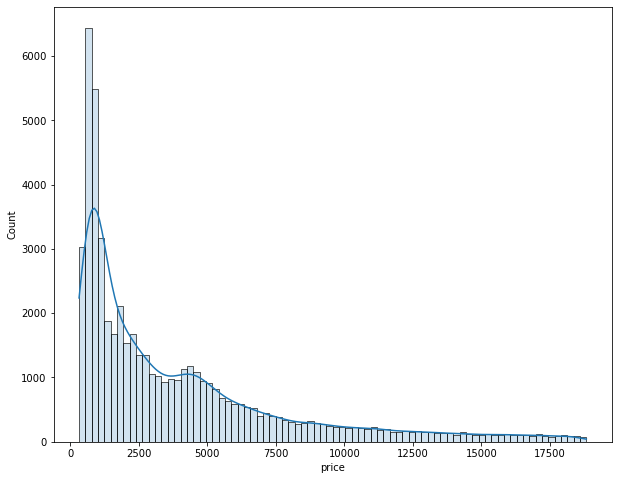

In [9]:
plt.figure(figsize=(10,8))
sns.histplot(data=df_train, x="price", kde=True, alpha = 0.2)

## Numerical Predictors Variables

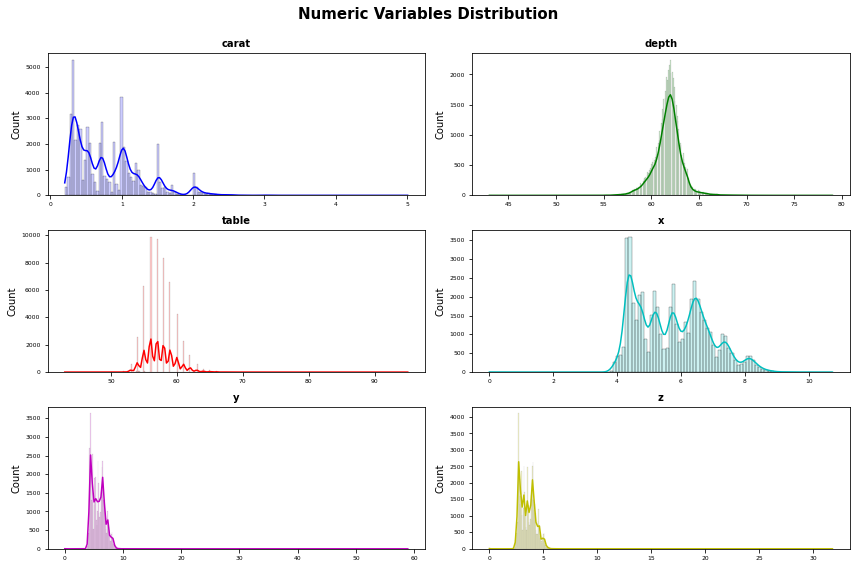

In [10]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize=(12, 8))
ax = ax.flat
numerical_cols = df_train.drop("price", axis=1).select_dtypes(include=["int", "float"]).columns

for ind, col in enumerate(numerical_cols):
    sns.histplot(data = df_train, 
                 x = col, 
                 color = list(mcolors.BASE_COLORS)[ind], 
                 kde=True, 
                 ax = ax[ind], 
                 alpha=0.2)
    
    ax[ind].set_title(col, fontsize = 10, fontweight = "bold")
    ax[ind].tick_params(labelsize = 6)
    ax[ind].set_xlabel("")
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle("Numeric Variables Distribution", fontsize = 15, fontweight = "bold");

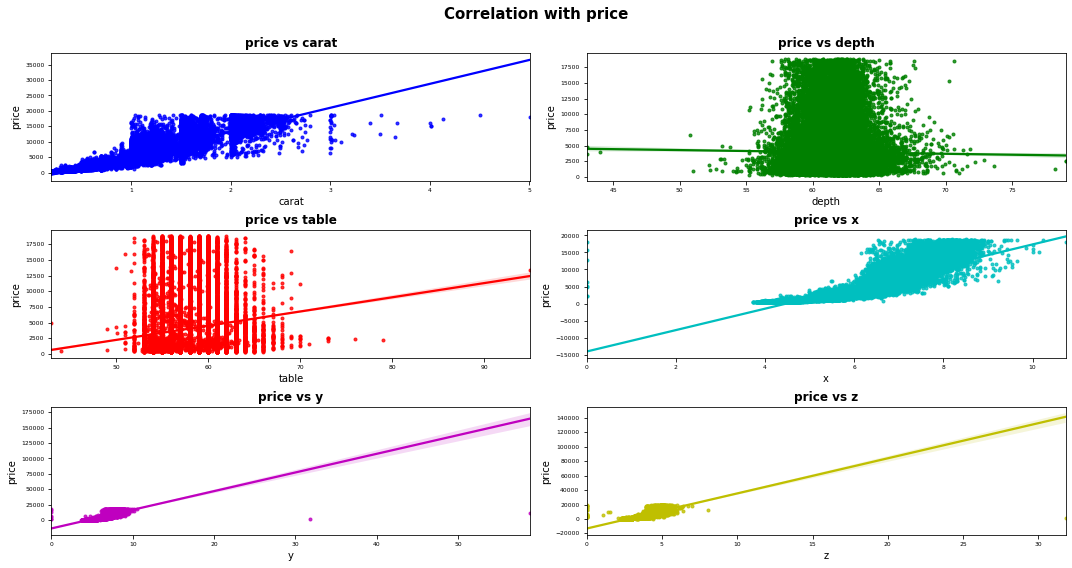

In [11]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize=(15,8))
ax = ax.flat
for ind, cols in enumerate(numerical_cols):
    sns.regplot(x = cols, 
                y = "price", 
                data = df_train, 
                color = list(mcolors.BASE_COLORS)[ind], 
                marker = ".", 
                ax = ax[ind])
    
    ax[ind].set_title(f"price vs {cols}", fontsize = 12, fontweight = "bold")
    ax[ind].tick_params(labelsize = 6)
    ax[ind].set_xlabel(f"{cols}")
    ax[ind].set_ylabel("price")

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle("Correlation with price", fontsize = 15, fontweight = "bold");

In [12]:
df_train.corr()

,Unnamed: 0,carat,depth,table,price,x,y,z
Unnamed: 0,1.000000,-0.377983,-0.034800,-0.100830,-0.306873,-0.405440,-0.395843,-0.399208
carat,-0.377983,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,-0.034800,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,-0.100830,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,-0.306873,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,-0.405440,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,-0.395843,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,-0.399208,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


<AxesSubplot:>

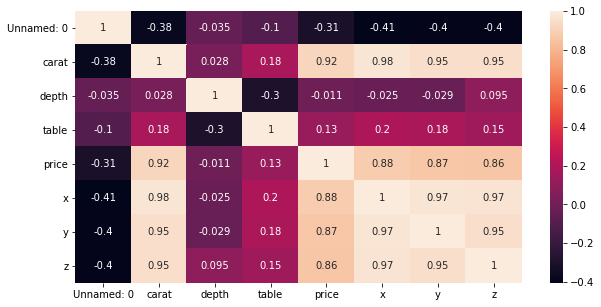

In [13]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_train.corr(), annot = True)

## Categorical Predictors Variables

Text(0.5, 0.98, 'Categorical Variables Distribution')

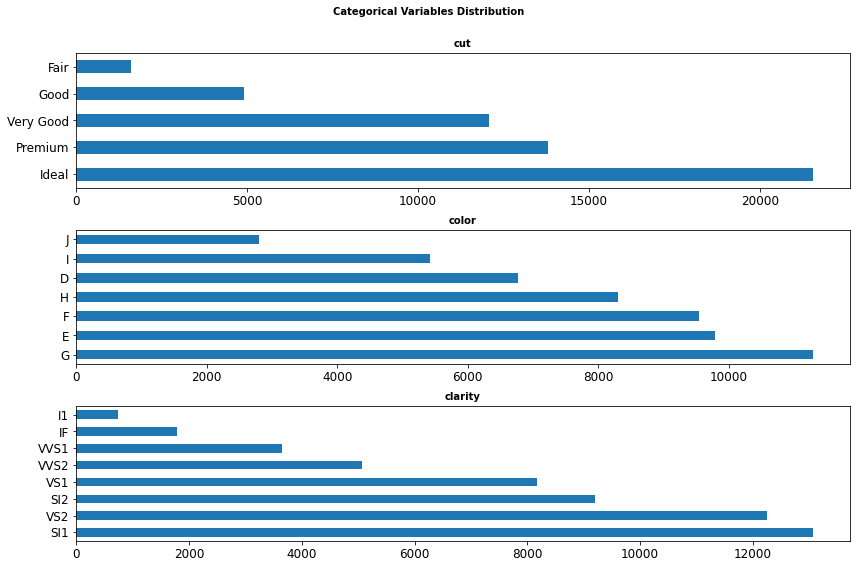

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,8))
ax = ax.flat
categorical_cols = df_train.select_dtypes(include=["object"]).columns
for ind, cols in enumerate(categorical_cols):
    df_train[cols].value_counts().plot.barh(ax=ax[ind])
    ax[ind].set_title(cols, fontsize=10, fontweight="bold")
    ax[ind].tick_params(labelsize=12)
    ax[ind].set_xlabel("")
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle("Categorical Variables Distribution", fontsize=10, fontweight="bold")

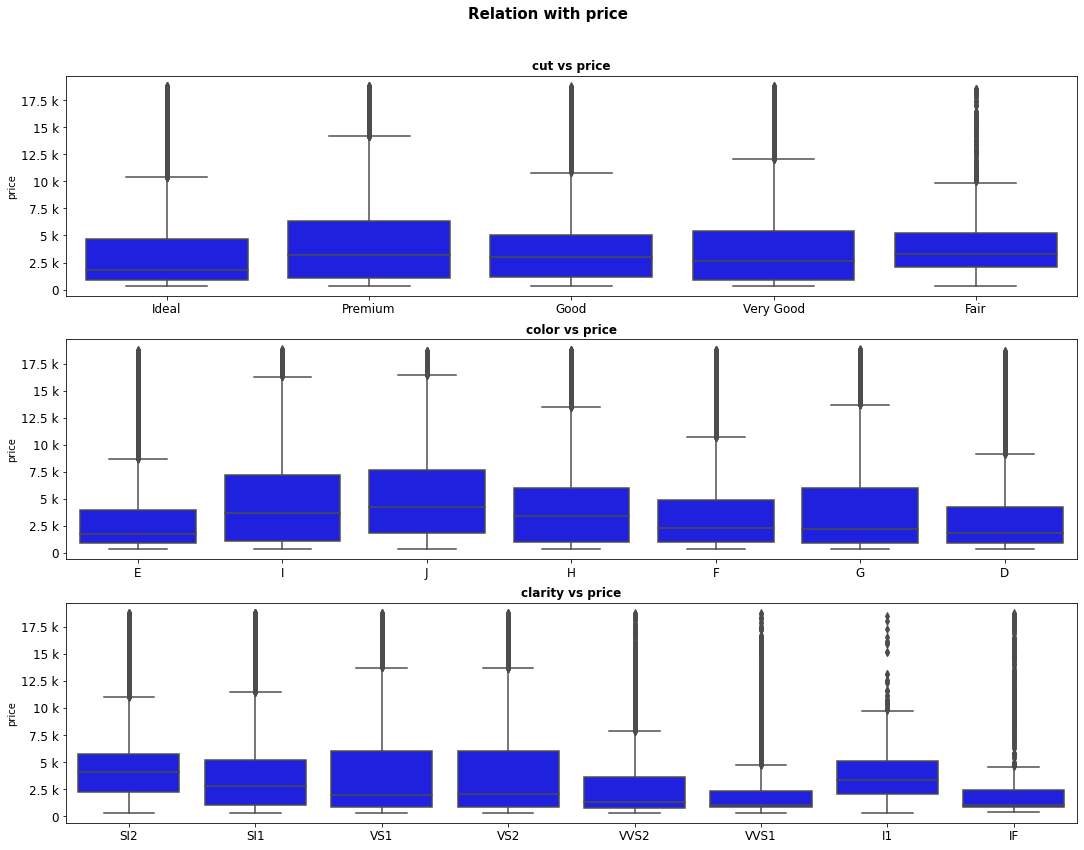

In [15]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(15,12))
ax = ax.flat
for ind, cols in enumerate(categorical_cols):
    sns.boxplot(x = cols, y="price", data=df_train, color="blue", ax=ax[ind])

    ax[ind].set_title(f"{cols} vs price", fontsize = 12, fontweight = "bold")
    ax[ind].yaxis.set_major_formatter(ticker.EngFormatter())
    ax[ind].tick_params(labelsize = 12)
    ax[ind].set_xlabel("")
    ax[ind].set_ylabel("price")

    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle("Relation with price", fontsize = 15, fontweight = "bold");

# Preprocessing Data

## Dropping ID Variable

As a first action, we will delete the `id` column because it does not give us any relevant information about the diamonds.

In [16]:
#drop columns: id -> Useless
df_train = df_train.drop("Unnamed: 0", axis=1)

## Encoding Categorical Variables

Now, let's check the values of the `object` type features.

In [17]:
#check uniques
df_train.clarity.unique()

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'],
      dtype=object)

In [18]:
df_train.cut.unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

In [19]:
df_train.color.unique()

array(['E', 'I', 'J', 'H', 'F', 'G', 'D'], dtype=object)

Going deeper into the diamond information, we have seen that the values of the three features (`clarity`, `cut`, and `color`) have a scale, that is, they follow an order.

Therefore, our strategy for converting these features to numerical is a hand encoding. By setting values from $1$ -> smallest value, to $n$ -> largest value.

We create dictionaries where the keys are the categorical value and the values are the numerical values that we assign to them.

In [20]:
#review diamond documentation and see that there 
#is numerical order in the categorical features. Encode the categorical features by numerical features.
encoding_cut =  {"Fair":1, "Good":2, 
          "Ideal":3, "Very Good":4, "Premium":5}
    
    
encoding_color = {'E':1,'D':2,'F':3,
             'G':4,'H':5,'I':6,
             'J':7}

encoding_clarity = {'I1':1,'SI2':2,
               'SI1':3,'VS2':4,'VS1':5,
               'VVS2':6,'VVS1':7,'IF':8}

Using the `.apply` method we apply a `lambda` function in which we change the categorical value by the numerical value to each column.

And store the numeric value in the DataFrame column to replace the values.

In [21]:
#replace categorical variables with numerical variables
df_train["cut"] = df_train["cut"].apply(lambda x: encoding_cut[x])
df_train["color"] = df_train["color"].apply(lambda x: encoding_color[x])
df_train["clarity"] = df_train["clarity"].apply(lambda x: encoding_clarity[x])

## Ols Regression

By means of `ols` we will check the influence of the variables on the target variable.

In [22]:
#Let's get the summary of the metrics.
#Set 'price' as target variable, and the rest as predictors variables. And, them, fit the model.
train_results = smf.ols(
    "price ~ carat + cut + color + clarity + table + depth + x + y + z",
    data=df_train).fit()
#We see the summary
train_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 5.717e+04
Date:                Sun, 18 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:33:11   Log-Likelihood:            -4.6025e+05
No. Observations:               53940   AIC:                         9.205e+05
Df Residuals:                   53930   BIC:                         9.206e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8849.2308    380.670     23.246      0.000    8103.114    9595.348
carat       1.069e+04     52.347    204.167      0.000    1.06e+04    1.08e+04
cut           92.8488      5.307     17.497      0.000      82.448     103.250
color       -294.3752      3.161    -93.140      0.000    -300.570    -288.180
clarity      502.5583      3.540    141.962      0.000     495.620     509.497
table        -67.1239      2.584    -25.976      0.000     -72.189     -62.059
depth        -98.6111      4.647    -21.223      0.000    -107.718     -89.504
x           -859.8736     35.576    -24.170      0.000    -929.604    -790.143
y             41.7165     20.960      1.990      0.047       0.634      82.799
z            -38.6496     36.378     -1.062      0.288    -109.952      32.653
==============================================================================
Omnibus:                    12166.846   Durbin-Watson:                   1.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           621515.145
Skew:                          -0.085   Prob(JB):                         0.00
Kurtosis:                      19.629   Cond. No.                     6.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As we can see, the `R-squared` label has a value of `0.952`. `R-squared` is the percentage of variation of the target variable that explains its relationship with one or more predictor variables. This value is between $0$ and $1$, and the closer to $1$ the better the fit of the model to data.

As can be seen the value of the variable `z` in $P>|t|$ is greater than $0.05$, so we will proceed to drop it.

In [23]:
#drop colums: z
df_train = df_train.drop("z", axis=1)

In [24]:
#recheck summary
train_results = smf.ols(
    "price ~ carat + cut + color + clarity + table + depth + x + y",
    data=df_train).fit()
#We see the summary
train_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 6.432e+04
Date:                Sun, 18 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:33:13   Log-Likelihood:            -4.6026e+05
No. Observations:               53940   AIC:                         9.205e+05
Df Residuals:                   53931   BIC:                         9.206e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8985.4617    358.425     25.069      0.000    8282.946    9687.978
carat       1.069e+04     52.346    204.164      0.000    1.06e+04    1.08e+04
cut           92.9234      5.306     17.512      0.000      82.523     103.323
color       -294.3483      3.160    -93.134      0.000    -300.543    -288.154
clarity      502.5078      3.540    141.960      0.000     495.570     509.446
table        -67.0927      2.584    -25.965      0.000     -72.157     -62.028
depth       -100.8685      4.132    -24.410      0.000    -108.968     -92.769
x           -880.4633     29.835    -29.511      0.000    -938.940    -821.987
y             38.7076     20.768      1.864      0.062      -1.998      79.414
==============================================================================
Omnibus:                    12169.270   Durbin-Watson:                   1.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           622005.836
Skew:                          -0.085   Prob(JB):                         0.00
Kurtosis:                      19.635   Cond. No.                     5.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We save the cleaned DataFrame in a `.csv` file.

In [25]:
#convert to .csv
df_train.to_csv("input/train_clean.csv", header=True, index=False)

# Creating Models

## X Y Split

To begin, we will perform a linear regression model as a means of predicting the price of diamonds based on the predictor variables we saw earlier.

We set the variable `X` for the predictor variables, and the variable `y` for the target variable.

In [26]:
#take predictors variables and response variable
X = df_train.drop("price", axis=1)
y = df_train["price"]

## Train Test Split

We use the `train_test_split` method to split the `X` and `y` into a 0.8 train and a 0.2 test.

We will train the model with the 0.8 selected by the method and test it with the 0.2 of the test.

In [27]:
#split the data 0.8 traon, 0.2 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=444)

## Random Forest Model with Hyperopt

In [37]:
params = {
        "n_estimators":hp.quniform("n_estimators", 10, 1000, 25),
        "max_depth":hp.quniform("max_depth", 4, 16, 1),
        "max_features":hp.quniform("max_features",2 ,8, 1),
        "min_samples_split":hp.quniform("min_samples_split", 2, 15, 1),
        "min_samples_leaf":hp.quniform("min_samples_leaf", 1,5,1)
}

In [38]:
def objetive(param):
    rf = RandomForestRegressor(n_estimators=int(param["n_estimators"]),
                      max_depth=int(param["max_depth"]),
                      max_features=int(param["max_features"]),
                      min_samples_split=int(param["min_samples_split"]),
                      min_samples_leaf=int(param["min_samples_leaf"]))
    
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    rmse = mse(y_test, y_pred)**(0.5)
    return {'loss':rmse, 'status': STATUS_OK }

In [39]:
trials_reg = Trials()
best = fmin(fn=objetive,
            space=params,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials_reg
            )

100%|██████████| 10/10 [07:38<00:00, 45.82s/trial, best loss: 526.636244234606]


In [44]:
best

{'max_depth': 15.0,
 'max_features': 5.0,
 'min_samples_leaf': 2.0,
 'min_samples_split': 9.0,
 'n_estimators': 100.0}

In [45]:
rf_model = RandomForestRegressor(
    n_estimators=int(best["n_estimators"]),
    max_depth=int(best["max_depth"]),
    max_features=int(best["max_features"]),
    min_samples_split=int(best["min_samples_split"]),
    min_samples_leaf=int(best["min_samples_leaf"])
)

In [49]:
rf_model.fit(X_train, y_train)
y_pred_test_rf=rf_model.predict(X_test)
rmse_rf = mse(y_test, y_pred_test_rf)**0.5
rmse_rf

530.3772716163513

In [86]:
pred_df = pd.DataFrame({"Real":y_test, "RFHyperopt": y_pred_test_rf})
pred_df.head()

,Real,RFHyperopt
31598,367,413.229907
23970,12105,12070.840517
38321,1020,1042.457407
46695,1791,1803.679082
10355,4770,5341.021539


## Pycaret

In [58]:
df_train[["cut", "color", "clarity"]] = df_train[["cut", "color", "clarity"]].apply(lambda x:x.astype("float64"))

In [59]:
df_train.dtypes

carat      float64
cut        float64
color      float64
clarity    float64
depth      float64
table      float64
price        int64
x          float64
y          float64
dtype: object

In [60]:
exp_clf101 = setup(data = df_train, target = "price", session_id=123)

,Description,Value
0,session_id,123
1,Target,price
2,Original Data,"(53940, 9)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(37757, 8)"


In [61]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,283.6176,292857.7584,540.6805,0.9816,0.1070,0.0821,0.3530
xgboost,Extreme Gradient Boosting,281.0910,298675.0797,546.1807,0.9812,0.0968,0.0728,1.5140
et,Extra Trees Regressor,272.6170,298320.7444,545.6725,0.9812,0.0928,0.0667,4.8900
rf,Random Forest Regressor,276.4072,303750.9810,550.7266,0.9809,0.0922,0.0665,6.3240
gbr,Gradient Boosting Regressor,345.7643,396057.4165,628.9765,0.9751,0.1641,0.1087,1.6310
dt,Decision Tree Regressor,371.0857,572214.4301,756.0138,0.9640,0.1265,0.0878,0.1330
knn,K Neighbors Regressor,502.4099,870448.9062,931.8603,0.9453,0.1851,0.1426,0.2270
ada,AdaBoost Regressor,834.9039,1262452.0482,1123.3555,0.9205,0.3853,0.3935,1.0940
lasso,Lasso Regression,817.1191,1536768.2250,1238.7735,0.9033,0.6626,0.4427,0.0580
ridge,Ridge Regression,816.6771,1601627.6875,1261.2938,0.8993,0.6592,0.4419,0.0300


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [62]:
lgbm_reg = create_model("lightgbm")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,278.5171,284237.0936,533.1389,0.9814,0.1041,0.0799
1,286.1279,289448.5340,538.0042,0.9823,0.1080,0.0839
2,282.8442,282761.5021,531.7532,0.9818,0.1072,0.0840
3,286.7021,308704.9497,555.6122,0.9816,0.1089,0.0812
4,284.0139,294806.6771,542.9610,0.9820,0.1064,0.0813
5,295.5963,324380.9695,569.5445,0.9792,0.1076,0.0832
6,296.3536,336555.7788,580.1343,0.9791,0.1132,0.0856
7,283.0652,296116.3248,544.1657,0.9814,0.1049,0.0810
8,268.9730,257900.1316,507.8387,0.9832,0.1047,0.0800
9,273.9828,253665.6225,503.6523,0.9837,0.1049,0.0811


In [63]:
tune_lgbm = tune_model(lgbm_reg, search_library="tune-sklearn", search_algorithm="hyperopt")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,306.2779,344856.1717,587.2446,0.9774,0.1181,0.0913
1,305.8355,323891.9150,569.1150,0.9802,0.1228,0.0954
2,303.7167,321165.3421,566.7145,0.9793,0.1200,0.0942
3,309.3892,354709.1751,595.5747,0.9789,0.1223,0.0928
4,303.2552,332912.4217,576.9856,0.9797,0.1229,0.0940
5,318.7189,368780.3999,607.2729,0.9763,0.1224,0.0951
6,319.9155,388019.2906,622.9119,0.9759,0.1284,0.0971
7,307.2867,338815.2821,582.0784,0.9787,0.1206,0.0933
8,291.7204,292129.5556,540.4901,0.9810,0.1209,0.0936
9,292.5826,293342.4059,541.6109,0.9812,0.1201,0.0921


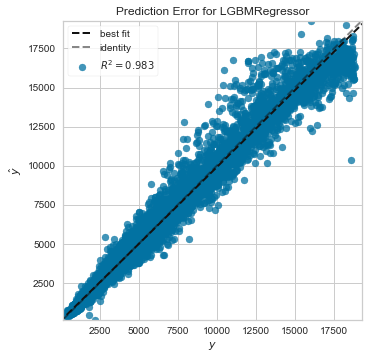

In [64]:
plot_model(lgbm_reg, plot = "error")

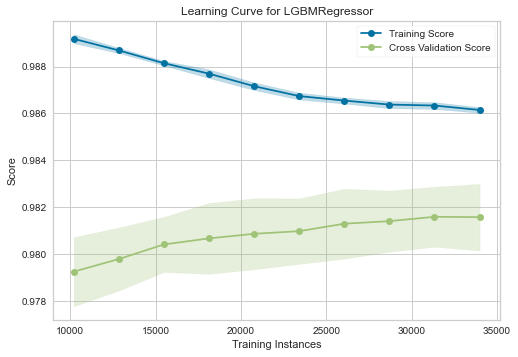

In [65]:
plot_model(lgbm_reg, plot = "learning")

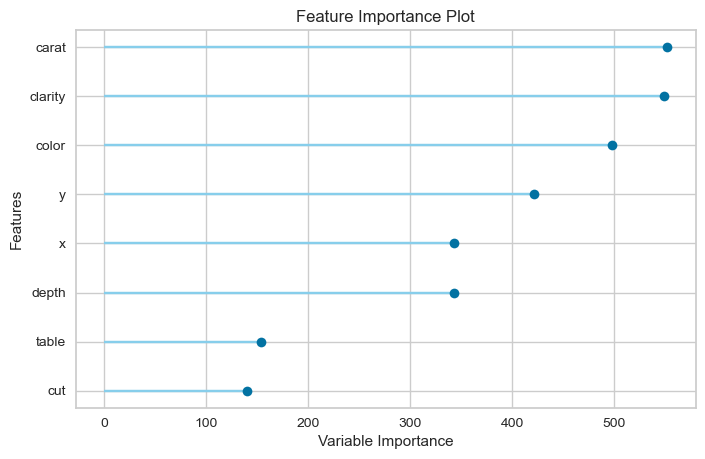

In [66]:
plot_model(lgbm_reg, plot="feature")

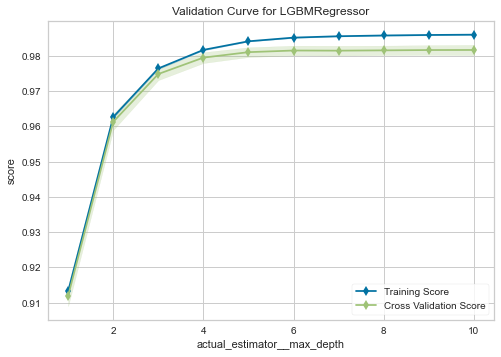

In [67]:
plot_model(lgbm_reg, plot="vc")

In [68]:
predict_model(lgbm_reg);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,275.2925,275012.2053,524.4161,0.9828,0.1081,0.0811


In [69]:
final_lgbm = finalize_model(lgbm_reg)

In [70]:
predict_model(final_lgbm);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,257.1780,216924.5510,465.7516,0.9864,0.1036,0.0790


In [71]:
y_pred_test_py = final_lgbm.predict(X_test)

In [91]:
rmse_py = mse(y_test, y_pred_test_py)**0.5
rmse_py

473.8998606000407

In [87]:
pred_df["Py_LGBM"] = y_pred_test_py
pred_df = pred_df.reset_index().drop("index", axis=1).head()

# Conclusion

In [88]:
pred_df.head()

,Real,RFHyperopt,Py_LGBM
0,367,413.229907,538.586674
1,12105,12070.840517,12006.442801
2,1020,1042.457407,1161.698318
3,1791,1803.679082,1701.542564
4,4770,5341.021539,5410.239085


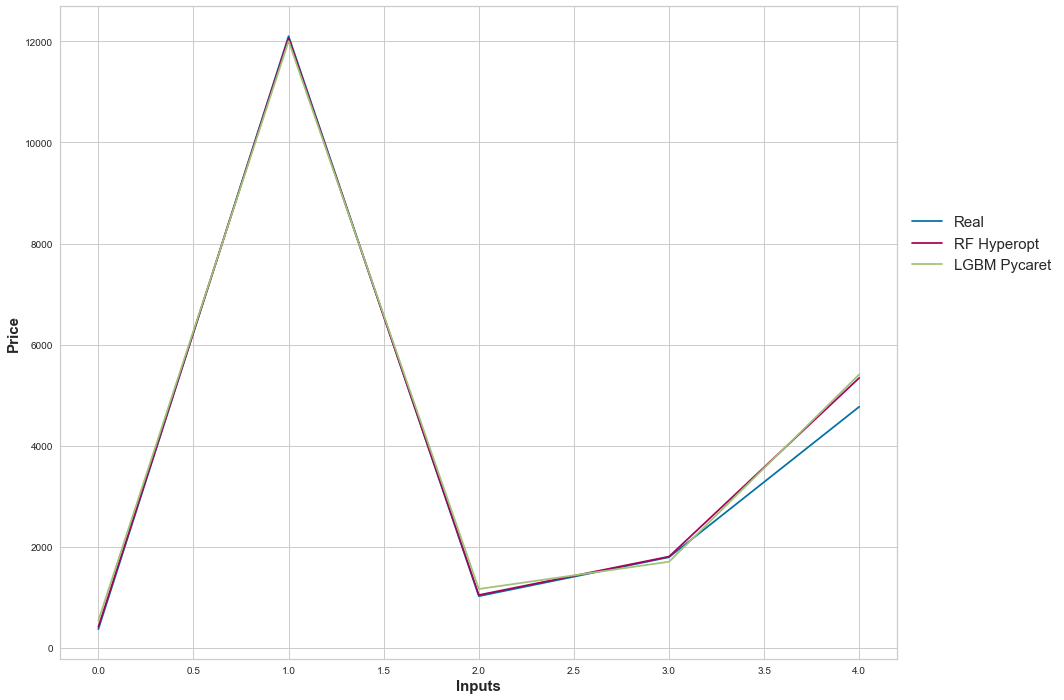

In [141]:
plt.figure(figsize=(15,12))

plt.plot(pred_df["Real"], label = "Real", color = "b")
plt.plot(pred_df["RFHyperopt"], label = "RF Hyperopt", color = "m")
plt.plot(pred_df["Py_LGBM"], label = "LGBM Pycaret", color = "g")

plt.xlabel("Inputs", fontsize = 15, fontweight = "bold")
plt.ylabel("Price", fontsize = 15, fontweight = "bold")

plt.legend(loc="best", bbox_to_anchor=(1.0, 0.2, 0.2, 0.5), fontsize = 15, shadow=True)
plt.show();

In [94]:
df_error = pd.DataFrame({
                        "Model": ["RamdomForest", "LightGBM"],
                        "RMSE": [rmse_rf, rmse_py]
                     }).sort_values("RMSE", ascending=False)

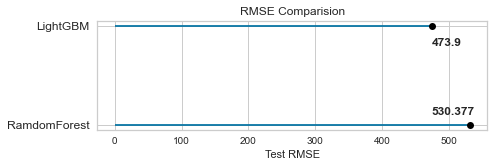

In [133]:
plt.figure(figsize=(7,2))
plt.hlines(df_error.Model, xmin=0, xmax=df_error.RMSE)
plt.plot(df_error.RMSE, df_error.Model, "o", color="black")
plt.tick_params(axis="y", labelsize=12)
plt.title("RMSE Comparision")
plt.xlabel("Test RMSE")
plt.text(x = rmse_py+0.5, y=0.8, s=rmse_py.round(3), fontdict={"weight": "bold","size": 12})
plt.text(x = rmse_py, y=0.1, s=rmse_rf.round(3), fontdict={"weight": "bold","size": 12})
plt.show;